In [1]:
import pandas as pd
import numpy as np
import torch
import torchsde
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools
import optuna
import matplotlib.pyplot as plt


dataset_path = r"..\..\datasets\petr4_options_data\processed_vale3_options.csv"
european_calls = pd.read_csv(dataset_path)
european_calls = european_calls[european_calls["type"] == "CALL"]

import ast

# Extract the 'price' value from the 'spot' column
def extract_price(spot_value):
    try:
        parsed = ast.literal_eval(spot_value)  # Parse the string as a dictionary
        return parsed.get("price")  # Extract 'price'
    except (ValueError, SyntaxError, AttributeError):
        return None  # Return None if parsing fails

# Apply extraction
european_calls["spot_price"] = european_calls["spot"].apply(extract_price)

european_calls = european_calls[european_calls["type"] == "CALL"]
european_calls

,symbol,time,spot,type,due_date,strike,premium,maturity_type,days_to_maturity,moneyness,delta,gamma,vega,theta,rho,volatility,poe,bs,variação,spot_price
1,VALEK731,2022-11-14T00:00:00.000Z,"{'price': 83.31, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,69.84,14.05,EUROPEAN,3,ITM,0.904787,0.014246,0.015389,-0.340185,0.007301,130.739,87.83,14.0499,-0.0001,83.31
3,VALEL692,2022-11-22T00:00:00.000Z,"{'price': 80.14, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,65.91,15.46,EUROPEAN,18,ITM,0.867014,0.013827,0.046025,-0.097052,0.038588,72.559,82.08,15.4599,-0.0001,80.14
4,VALEG845,2022-11-24T00:00:00.000Z,"{'price': 81.45, 'symbol': 'VALE3'}",CALL,2023-07-21T00:00:00.000Z,81.16,12.80,EUROPEAN,171,ATM,0.592590,0.012618,0.260428,-0.037727,0.240665,45.847,44.30,12.7999,-0.0001,81.45
5,VALEL752,2022-11-28T00:00:00.000Z,"{'price': 81.3, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,71.91,10.38,EUROPEAN,13,ITM,0.844522,0.022495,0.044091,-0.102105,0.030065,57.483,81.13,10.3799,-0.0001,81.30
6,VALEL772,2022-11-17T00:00:00.000Z,"{'price': 83.1, 'symbol': 'VALE3'}",CALL,2022-12-16T00:00:00.000Z,73.91,9.96,EUROPEAN,21,ITM,0.868255,0.022960,0.051217,-0.052206,0.051826,38.763,84.29,9.9599,-0.0001,83.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6242,VALEK611,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,57.84,19.72,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.004589,0.011471,0.000,100.00,24.4829,4.7629,82.30
6243,VALEK493,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,49.34,28.19,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.003914,0.009786,0.000,100.00,32.9796,4.7896,82.30
6245,VALEK518,2022-11-11T00:00:00.000Z,"{'price': 82.3, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,51.84,25.60,EUROPEAN,5,ITM,1.000000,0.000000,0.000000,-0.004113,0.010281,0.000,100.00,30.4806,4.8806,82.30
6254,VALEK718,2022-11-16T00:00:00.000Z,"{'price': 82.44, 'symbol': 'VALE3'}",CALL,2022-11-18T00:00:00.000Z,71.84,10.30,EUROPEAN,2,ITM,0.721802,0.012608,0.024646,-2.236221,0.003447,362.397,60.46,16.0758,5.7758,82.44


In [2]:
data = european_calls
# Stratified split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(data, data['moneyness']):
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

# Add Risk-Free Rate (constant for November 2022)
risk_free_rate = 0.1375  # Selic rate for Brazil in November 2022: https://g1.globo.com/economia/noticia/2022/08/03/copom-eleva-selic-para-1375percent-e-juro-basico-da-economia-chega-ao-maior-patamar-em-seis-anos.ghtml
train_data['RISK_FREE_RATE'] = risk_free_rate
test_data['RISK_FREE_RATE'] = risk_free_rate

# Handle outliers in PREMIUM by capping extreme values
price_upper_limit = train_data['premium'].quantile(0.99)
price_lower_limit = train_data['premium'].quantile(0.01)
train_data['premium'] = train_data['premium'].clip(lower=price_lower_limit, upper=price_upper_limit)

# Define features

features = ['rho',
     'theta',
    'gamma',
    'spot_price',
    "strike",
    "days_to_maturity",
    "volatility",
            
]
target = 'premium'

# Drop MONEYNESS_CATEGORY (it is a string)
train_data = train_data.drop(columns=['moneyness'])
test_data = test_data.drop(columns=['moneyness'])

# Scale with RobustScaler;
# Similar to normalization but it instead uses the interquartile range, so that it is robust to outliers.
# https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler
scaler = RobustScaler()
X_train = scaler.fit_transform(train_data[features])
X_test = scaler.transform(test_data[features])
y_train = train_data[target].values
y_test = test_data[target].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


C:\Users\USUARIO\AppData\Local\Temp\ipykernel_23956\2570647110.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_23956\2570647110.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['RISK_FREE_RATE'] = risk_free_rate
C:\Users\USUARIO\AppData\Local\Temp\ipykernel_23956\2570647110.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [3]:
# ------------------------- Neural SDE Model ------------------------- #
class TunableNeuralSDE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(TunableNeuralSDE, self).__init__()
        self.activation = activation
        self.f = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, output_dim)
        )
        self.g = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, hidden_dim),
            self.activation,
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, t, x):
        drift = self.f(x)
        diffusion = self.g(x)
        return drift, diffusion

# ------------------------- Hyperparameter Tuning ------------------------- #
# Hyperparameter space
hidden_dims = [64, 128, 256]
activations = [nn.ReLU(), nn.LeakyReLU(), nn.ELU()]
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64, 128]

# Search over hyperparameters
best_mse = float('inf')
best_params = None

for hidden_dim, activation, lr, batch_size in itertools.product(hidden_dims, activations, learning_rates, batch_sizes):
    # Initialize model
    model = TunableNeuralSDE(input_dim=len(features), hidden_dim=hidden_dim, output_dim=1, activation=activation)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for epoch in range(10):  # Train for fewer epochs to test configurations
        model.train()
        perm = torch.randperm(X_train_tensor.size(0))
        for i in range(0, X_train_tensor.size(0), batch_size):
            idx = perm[i:i + batch_size]
            X_batch = X_train_tensor[idx]
            y_batch = y_train_tensor[idx]

            optimizer.zero_grad()
            drift, diffusion = model(0, X_batch)
            loss = loss_fn(drift.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        drift_test, _ = model(0, X_test_tensor)
        mse = loss_fn(drift_test.squeeze(), y_test_tensor).item()

    # Best config
    if mse < best_mse:
        best_mse = mse
        best_params = {
            'hidden_dim': hidden_dim,
            'activation': activation,
            'learning_rate': lr,
            'batch_size': batch_size,
            'mse': mse
        }

    print(f"Test MSE: {mse:.4f}, Params: {hidden_dim}, {activation}, {lr}, {batch_size}")

# Print best parameters
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

Test MSE: 2.9440, Params: 64, ReLU(), 0.001, 32
Test MSE: 3.7996, Params: 64, ReLU(), 0.001, 64
Test MSE: 11.3098, Params: 64, ReLU(), 0.001, 128
Test MSE: 4.4212, Params: 64, ReLU(), 0.0005, 32
Test MSE: 14.9063, Params: 64, ReLU(), 0.0005, 64
Test MSE: 29.6263, Params: 64, ReLU(), 0.0005, 128
Test MSE: 35.4980, Params: 64, ReLU(), 0.0001, 32
Test MSE: 65.7427, Params: 64, ReLU(), 0.0001, 64
Test MSE: 82.8522, Params: 64, ReLU(), 0.0001, 128
Test MSE: 2.1105, Params: 64, LeakyReLU(negative_slope=0.01), 0.001, 32
Test MSE: 4.7471, Params: 64, LeakyReLU(negative_slope=0.01), 0.001, 64
Test MSE: 15.4659, Params: 64, LeakyReLU(negative_slope=0.01), 0.001, 128
Test MSE: 4.0694, Params: 64, LeakyReLU(negative_slope=0.01), 0.0005, 32
Test MSE: 14.1216, Params: 64, LeakyReLU(negative_slope=0.01), 0.0005, 64
Test MSE: 26.6105, Params: 64, LeakyReLU(negative_slope=0.01), 0.0005, 128
Test MSE: 40.2538, Params: 64, LeakyReLU(negative_slope=0.01), 0.0001, 32
Test MSE: 66.9393, Params: 64, LeakyReL

In [4]:
"""
Best Hyperparameters:
hidden_dim: 256
activation: ELU(alpha=1.0)
learning_rate: 0.001
batch_size: 32
mse: 0.5188284516334534
"""
# Defining now, as it comes in handy :)
def evaluate_model(true, predicted, model_name):
    mse = mean_squared_error(true, predicted)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    percent_error = np.abs((true - predicted) / true) * 100
    pe5 = np.mean(percent_error <= 5) * 100  # Percentage of predictions within 5% error
    pe10 = np.mean(percent_error <= 10) * 100  # Percentage of predictions within 10% error
    pe20 = np.mean(percent_error <= 20) * 100  # Percentage of predictions within 20% error

    
    print(f"\n{model_name} Performance:")
    print(f"  MSE: {mse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}")
    print(f"  PE5: {pe5:.2f}%")
    print(f"  PE10: {pe10:.2f}%")
    print(f"  PE20: {pe20:.2f}%")

# MAPE 
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

best_model = TunableNeuralSDE(
    input_dim=len(features),
    hidden_dim=256,  # Best hidden_dim
    output_dim=1,
    activation=nn.ELU(alpha=1.0),  # Best activation
)

# Optimizer and loss function
optimizer = optim.Adam(best_model.parameters(), lr=0.001)  # Best learning rate
loss_fn = nn.MSELoss()

# Training setup
n_epochs = 50  # Train for more epochs now
batch_size = 32  # Best batch size
learning_rate_history = []

# Training loop
for epoch in range(n_epochs):
    best_model.train()
    perm = torch.randperm(X_train_tensor.size(0))
    batch_loss = 0

    for i in range(0, X_train_tensor.size(0), batch_size):
        idx = perm[i:i + batch_size]
        X_batch = X_train_tensor[idx]
        y_batch = y_train_tensor[idx]

        optimizer.zero_grad()
        drift, diffusion = best_model(0, X_batch)
        loss = loss_fn(drift.squeeze(), y_batch)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
    epoch_loss = batch_loss / (X_train_tensor.size(0) // batch_size)
    learning_rate_history.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {batch_loss / (X_train_tensor.size(0) // batch_size):.4f}")

# Evaluation on the test set
best_model.eval()
with torch.no_grad():
    drift_test, _ = best_model(0, X_test_tensor)
    drift_test_np = drift_test.squeeze().numpy()
    y_test_np = y_test_tensor.numpy()

    evaluation = evaluate_model(y_test_np, drift_test_np, "NeuralSDE")
    
print(evaluation)

Epoch 1/50, Loss: 29.9373
Epoch 2/50, Loss: 5.8273
Epoch 3/50, Loss: 3.1346
Epoch 4/50, Loss: 2.1725
Epoch 5/50, Loss: 1.3557
Epoch 6/50, Loss: 1.0135
Epoch 7/50, Loss: 0.7924
Epoch 8/50, Loss: 0.6675
Epoch 9/50, Loss: 0.5433
Epoch 10/50, Loss: 0.4927
Epoch 11/50, Loss: 0.4685
Epoch 12/50, Loss: 0.5878
Epoch 13/50, Loss: 0.4373
Epoch 14/50, Loss: 0.4227
Epoch 15/50, Loss: 0.4081
Epoch 16/50, Loss: 0.4152
Epoch 17/50, Loss: 0.4090
Epoch 18/50, Loss: 0.3581
Epoch 19/50, Loss: 0.3529
Epoch 20/50, Loss: 0.3298
Epoch 21/50, Loss: 0.4374
Epoch 22/50, Loss: 0.4324
Epoch 23/50, Loss: 0.5024
Epoch 24/50, Loss: 0.3214
Epoch 25/50, Loss: 0.3851
Epoch 26/50, Loss: 0.2979
Epoch 27/50, Loss: 0.4020
Epoch 28/50, Loss: 0.3119
Epoch 29/50, Loss: 0.2934
Epoch 30/50, Loss: 0.3059
Epoch 31/50, Loss: 0.2841
Epoch 32/50, Loss: 0.3384
Epoch 33/50, Loss: 0.3673
Epoch 34/50, Loss: 0.3031
Epoch 35/50, Loss: 0.3682
Epoch 36/50, Loss: 0.6437
Epoch 37/50, Loss: 0.3528
Epoch 38/50, Loss: 0.2773
Epoch 39/50, Loss: 0

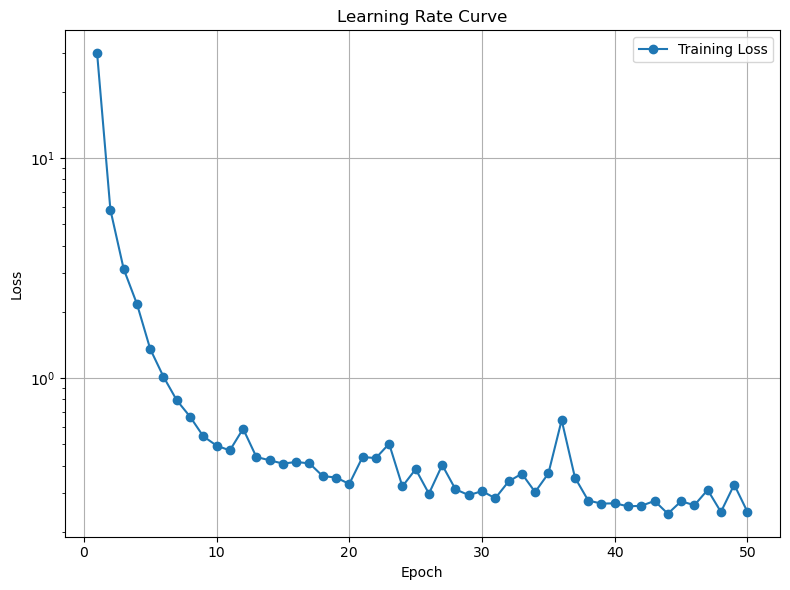

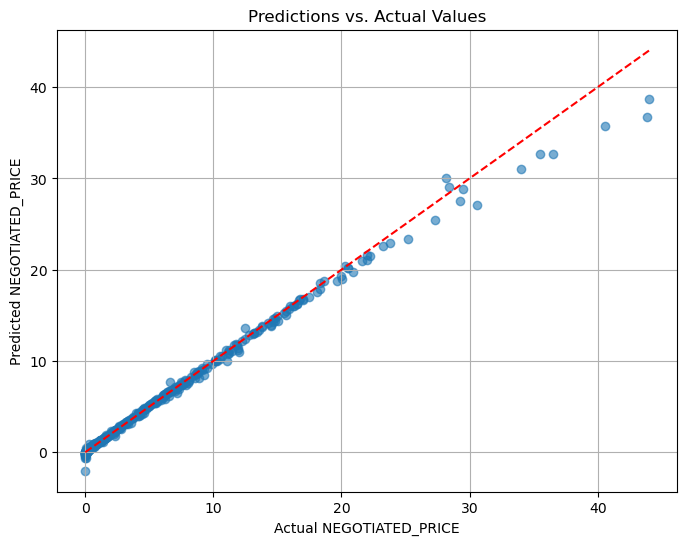

In [5]:
# Predictions vs. actual values
import matplotlib.pyplot as plt


# Plot learning rate (loss reduction) over epochs
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_epochs + 1), learning_rate_history, marker='o', label="Training Loss")
plt.title("Learning Rate Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, drift_test.squeeze().numpy(), alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual NEGOTIATED_PRICE")
plt.ylabel("Predicted NEGOTIATED_PRICE")
plt.title("Predictions vs. Actual Values")
plt.grid()
plt.show()


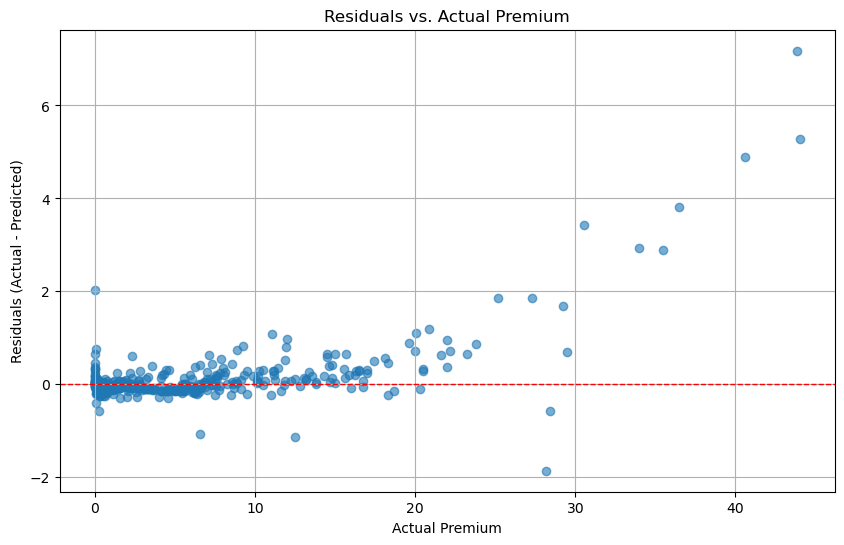

In [6]:
# Assuming y_test and drift_test values are already defined from the earlier folds
actual_values = y_test  # Replace with actual NEGOTIATED_PRICE values
predicted_values = drift_test.squeeze().numpy()  # Replace with predicted values from the best model

# Calculate residuals
residuals = actual_values - predicted_values

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs. Actual Premium")
plt.xlabel("Actual Premium")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid()
plt.show()



In [7]:
data = european_calls


itm_options = european_calls[european_calls["moneyness"] == "ITM"]
atm_options = european_calls[european_calls["moneyness"] == "ATM"]
otm_options = european_calls[european_calls["moneyness"] == "OTM"]

# Stratified split
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in stratified_split.split(data, data['moneyness']):
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

# Split training data into ITM, ATM, and OTM segments
train_ITM = train_data[train_data['moneyness'] == 'ITM']
train_ATM = train_data[train_data['moneyness'] == 'ATM']
train_OTM = train_data[train_data['moneyness'] == 'OTM']

# Split test data into ITM, ATM, and OTM segments
test_ITM = test_data[test_data['moneyness'] == 'ITM']
test_ATM = test_data[test_data['moneyness'] == 'ATM']
test_OTM = test_data[test_data['moneyness'] == 'OTM']

# Initialize a dictionary to store models for each segment
segment_models = {}
segments = {
    'ITM': (train_ITM, test_ITM),
    'ATM': (train_ATM, test_ATM),
    'OTM': (train_OTM, test_OTM)
}

# Train separate Tunable Neural SDE models for each segment
for segment, (train_segment, test_segment) in segments.items():
    X_train_segment = train_segment[features].values
    y_train_segment = train_segment[target].values
    X_test_segment = test_segment[features].values
    y_test_segment = test_segment[target].values

    # Convert data to tensors
    X_train_tensor = torch.tensor(X_train_segment, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_segment, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_segment, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_segment, dtype=torch.float32)

    # Train a Tunable Neural SDE model
    model = TunableNeuralSDE(
        input_dim=len(features),
        hidden_dim=512, 
        output_dim=1,
        activation=nn.ELU(alpha=1.0)
    )

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(150):  # Fixed epochs for all segments
        model.train()
        optimizer.zero_grad()
        drift, _ = model(0, X_train_tensor)
        loss = loss_fn(drift.squeeze(), y_train_tensor)
        loss.backward()
        optimizer.step()

    # Evaluate and store the model
    model.eval()
    with torch.no_grad():
        drift_test, _ = model(0, X_test_tensor)
        predictions = drift_test.squeeze().numpy()
        mse = loss_fn(drift_test.squeeze(), y_test_tensor).item()
        mape = mean_absolute_percentage_error(y_test_segment, predictions)

    segment_models[segment] = {
        'model': model,
        'test_data': (X_test_segment, y_test_segment),
        'predictions': predictions,
        'mse': mse,
        'mape': mape
    }

# Display performance metrics for each segment
for segment, results in segment_models.items():
    print(f"\nSegment: {segment}")
    print(f"  Test MSE: {results['mse']:.4f}")
    print(f"  Test MAPE: {results['mape']:.2f}%")



Segment: ITM
  Test MSE: 0.4011
  Test MAPE: 2.65%

Segment: ATM
  Test MSE: 0.4946
  Test MAPE: 20.05%

Segment: OTM
  Test MSE: 0.2247
  Test MAPE: 320.92%


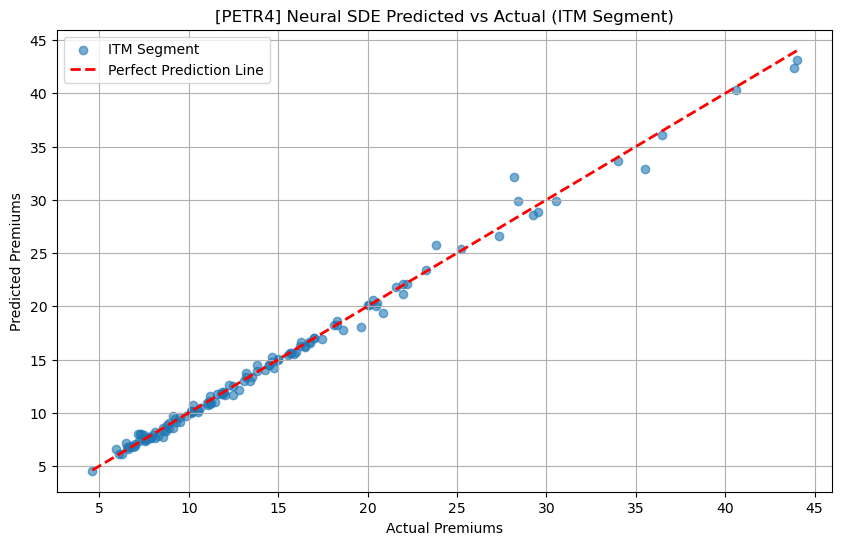

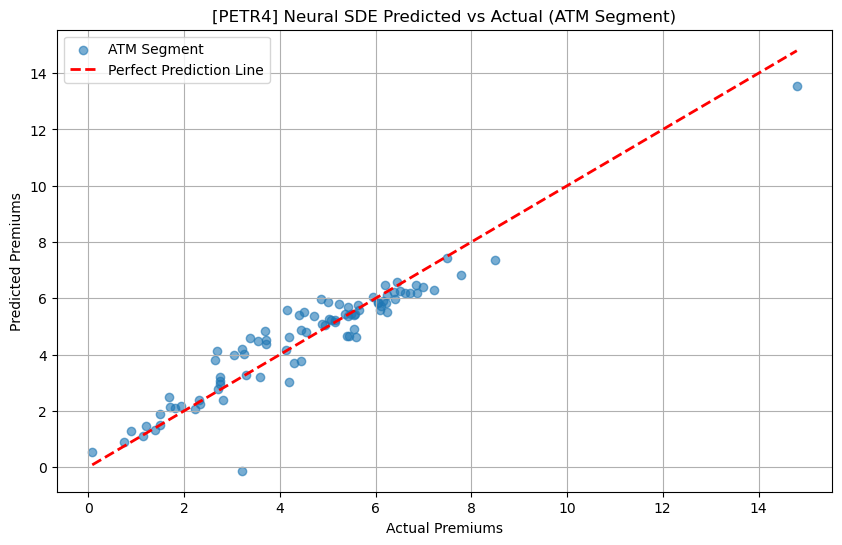

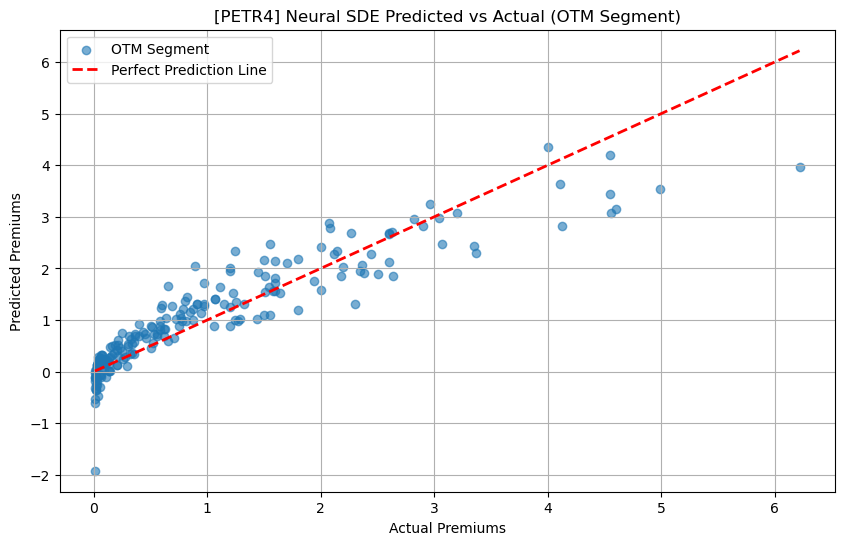

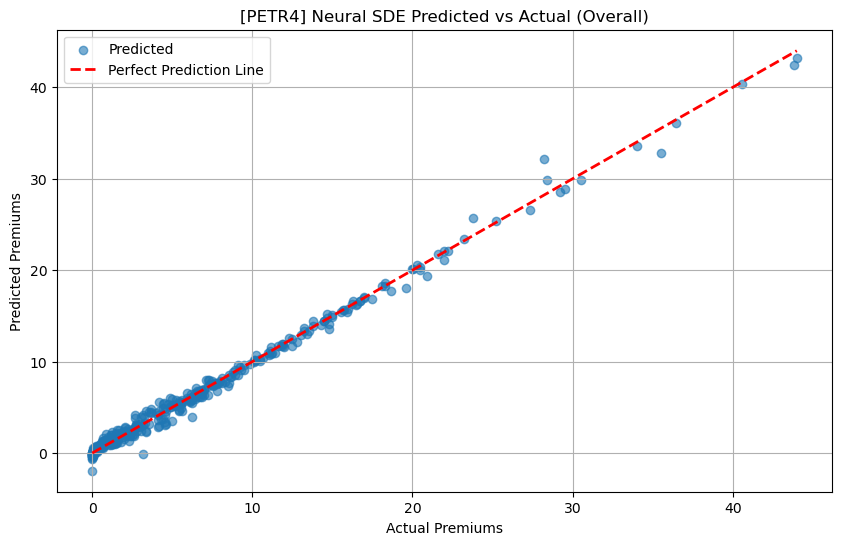

In [8]:
# Predicted vs Actual for each segment
for segment in segments.keys():
    y_test = segment_models[segment]['test_data'][1]  # Actual y_test
    predictions = segment_models[segment]['predictions']  # Predicted values

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.6, label=f'{segment} Segment')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
    plt.title(f"[PETR4] Neural SDE Predicted vs Actual ({segment} Segment)")
    plt.xlabel("Actual Premiums")
    plt.ylabel("Predicted Premiums")
    plt.legend()
    plt.grid(True)
    plt.show()

# Combine data for overall comparison
y_test_overall = np.concatenate([segment_models[segment]['test_data'][1] for segment in segments.keys()])
predictions_overall = np.concatenate([segment_models[segment]['predictions'] for segment in segments.keys()])

# Overall dataset visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test_overall, predictions_overall, alpha=0.6, label="Predicted")
plt.plot([y_test_overall.min(), y_test_overall.max()], [y_test_overall.min(), y_test_overall.max()], 'r--', lw=2, label="Perfect Prediction Line")  # Perfect prediction line
plt.title("[PETR4] Neural SDE Predicted vs Actual (Overall)")
plt.xlabel("Actual Premiums")
plt.ylabel("Predicted Premiums")
plt.legend()
plt.grid(True)
plt.show()
